**a.i. Depression Classification**

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

**Cleaning**

In [2]:
#Function to clean the data
def data_cleaning(file_path):
    df = pd.read_csv(file_path, index_col=0)
    df.dropna(inplace=True)

    return df

In [3]:
train_file = "/content/sample_data/final_training_data.csv"
test_file = "/content/sample_data/final_testing_data.csv"

# train_file = "../Datasets/ADS/final_training_data.csv"
# test_file = "../Datasets/ADS/final_testing_data.csv"

#After data exploring we found that one of the data sample's turn was all NA. So we removed it
train_data_source = data_cleaning(train_file)
test_data = data_cleaning(test_file)

**Training**

In [17]:
from sklearn.model_selection import train_test_split

#Select the features and target variables from the train set
X_tr = train_data_source.drop(['Depression', 'Gender', 'participant_id'], axis=1)
y_tr = train_data_source['Depression']
feature_names = X_tr.columns

#Normalize the data using standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)

#Split the data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_tr_scaled, y_tr, test_size=0.2, random_state=42)


In [18]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(10900, 88) (2725, 88) (10900,) (2725,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 20, 40],  # Maximum number of levels in tree
    'min_samples_split': [5, 10]  # Minimum number of samples required to split a node
}

#Initialize the classifier
rf = RandomForestClassifier(random_state=42)

#Setup the grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

#Fit grid_search to the data
grid_search.fit(X_train, y_train)


#Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

#Best model from grid search
best_rf = grid_search.best_estimator_

#Predict on the validation set
y_pred = best_rf.predict(X_val)

#Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

In [20]:
rf_best = RandomForestClassifier(max_depth=None, max_features= 'sqrt', min_samples_split= 5,
                                    n_estimators=300, random_state=42)
rf_best.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=300, random_state=42)

**Performing predictions on the test data**

In [21]:
#Function to aggregate turn-based decisions at the participant level
def aggregate_decisions(decisions):
    return int(decisions.mean() >= 0.5)

In [22]:
#Select the features and target variables from the test set
X_test = test_data.drop(['Depression', 'Gender', 'participant_id'], axis=1)
y_test = test_data['Depression']

#Normalize the test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)

#Make predictions on the test set
y_pred_test = rf_best.predict(X_test)

In [23]:
'''
Aggregrate predictions on a participant level
'''
#Get the participant IDs and genders for the test set
participant_ids_test = test_data['participant_id']
genders_test = test_data['Gender']

#Aggregate the predictions at the participant level
def aggregate_predictions(y_pred_test):
  participant_preds_test = {} #Have turns predictions for each participant
  for participant_id, pred in zip(participant_ids_test, y_pred_test):
      if participant_id not in participant_preds_test:
          participant_preds_test[participant_id] = []
      participant_preds_test[participant_id].append(pred)

  participant_final_preds_test = {} #Store aggregrated results
  for participant_id, preds in participant_preds_test.items():
      participant_final_preds_test[participant_id] = aggregate_decisions(pd.Series(preds))
  return participant_final_preds_test

In [24]:
#Evaluate the predictions against the true labels
participant_final_preds_test = aggregate_predictions(y_pred_test)
y_true_test = y_test.groupby(participant_ids_test).mean().round().astype(int)
y_pred_final_test = pd.Series(participant_final_preds_test)

In [31]:
#Calculate accuracy and balanced accuracy
accuracy_test = accuracy_score(y_true_test, y_pred_final_test)
balanced_accuracy_test = balanced_accuracy_score(y_true_test, y_pred_final_test)

#Calculate equality of opportunity (EO) for the test set
def calculate_tpr(y_true_test, y_pred_final_test):
  genders_test_aggregated = genders_test.groupby(participant_ids_test).first()
  male_mask_test = (genders_test_aggregated == 1)
  female_mask_test = (genders_test_aggregated == 0)

  tpr_male_test = accuracy_score(y_true_test[male_mask_test], y_pred_final_test[male_mask_test])
  tpr_female_test = accuracy_score(y_true_test[female_mask_test], y_pred_final_test[female_mask_test])

  return [male_mask_test, female_mask_test, tpr_male_test, tpr_female_test]

mask_and_tpr = calculate_tpr(y_true_test, y_pred_final_test)
male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0], mask_and_tpr[1], mask_and_tpr[2], mask_and_tpr[3]
eo_test = 1 - abs(tpr_male_test - tpr_female_test)

In [32]:
#Print the evaluation metrics for the test set
print("Test Accuracy:", accuracy_test)
print("Test Balanced Accuracy:", round(balanced_accuracy_test,3))
print("Test Equality of Opportunity (EO):", round(eo_test,3))

#Print the evaluation metrics for male and female participants separately
print("Male Accuracy:", round(tpr_male_test,3))
print("Female Accuracy:", round(tpr_female_test,3))
print("Male Balanced Accuracy:", round(balanced_accuracy_score(y_true_test[male_mask_test], y_pred_final_test[male_mask_test]),3))
print("Female Balanced Accuracy:", balanced_accuracy_score(y_true_test[female_mask_test], y_pred_final_test[female_mask_test]))

Test Accuracy: 0.65
Test Balanced Accuracy: 0.464
Test Equality of Opportunity (EO): 0.542
Male Accuracy: 0.833
Female Accuracy: 0.375
Male Balanced Accuracy: 0.455
Female Balanced Accuracy: 0.5


**Feature Selection**

In [27]:
#Feature selection using mutual information

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix

info = mutual_info_classif(X_train, y_train)
features_ranked = feature_names[np.argsort(-info)]

In [33]:
selected_features = features_ranked[:20]
print(selected_features)

Index(['loudness_sma3_pctlrange0-2', 'equivalentSoundLevel_dBp',
       'loudness_sma3_percentile80.0', 'loudness_sma3_amean',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'spectralFluxV_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'loudness_sma3_meanFallingSlope', 'loudness_sma3_meanRisingSlope',
       'mfcc2_sma3_stddevNorm', 'loudness_sma3_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_amean', 'spectralFlux_sma3_amean',
       'slopeV500-1500_sma3nz_stddevNorm', 'mfcc2V_sma3nz_amean',
       'F2frequency_sma3nz_amean', 'mfcc3V_sma3nz_stddevNorm',
       'shimmerLocaldB_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_amean'],
      dtype='object')


In [38]:
def aggregate_predictions(predictions, ids, genders):
    df = pd.DataFrame({'id': ids, 'prediction': predictions, 'gender': genders})
    df_aggregated = df.groupby('id').agg(
        prediction=('prediction', lambda x: np.round(x.mean()).astype(int)),
        gender=('gender', 'first')
    )
    return df_aggregated

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    ba = 0.5 * (cm[0, 0] / cm[0,:].sum() + cm[1, 1] / cm[1,:].sum())
    return accuracy, ba

In [41]:
# Evaluation over different numbers of top features
n_features = [10, 15, 20, 25, 30, 35, 40, 45, 50, 88]
results = []

ids_test = test_data['participant_id']
genders_test = test_data['Gender']

for n in n_features:
    selected_features = features_ranked[:n]
    selected_feature_indices = [feature_names.get_loc(name) for name in selected_features]
    rf_best.fit(X_train[:, selected_feature_indices], y_train)
    y_pred = rf_best.predict(X_test[:, selected_feature_indices])

    y_pred_aggregated = aggregate_predictions(y_pred, ids_test, genders_test)
    y_test_aggregated = aggregate_predictions(y_test.values, ids_test, genders_test)

    acc, ba = evaluate_metrics(y_test_aggregated['prediction'], y_pred_aggregated['prediction'])

    mask_and_tpr = calculate_tpr(y_test_aggregated['prediction'], y_pred_aggregated['prediction'])
    male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0], mask_and_tpr[1], mask_and_tpr[2], mask_and_tpr[3]
    eo = 1 - abs(tpr_male_test - tpr_female_test)

    print(f"No of features: {n} ; acc: {acc} ; ba: {round(ba,3)}, eo:{round(eo,3)}")
    results.append((n, acc, round(ba,3), round(eo,3)))

No of features: 10 ; acc: 0.6 ; ba: 0.429, eo:0.625
No of features: 15 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 20 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 25 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 30 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 35 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 40 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 45 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 50 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 88 ; acc: 0.65 ; ba: 0.464, eo:0.542


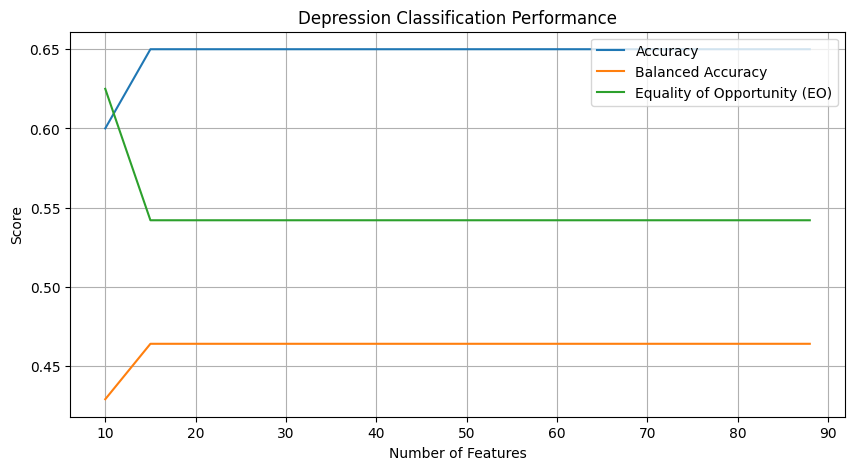

In [42]:
# Plotting the results
results = np.array(results)
plt.figure(figsize=(10, 5))
plt.plot(results[:, 0], results[:, 1], label='Accuracy')
plt.plot(results[:, 0], results[:, 2], label='Balanced Accuracy')
plt.plot(results[:, 0], results[:, 3], label='Equality of Opportunity (EO)')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Depression Classification Performance')
plt.legend()
plt.grid(True)
plt.show()